In [65]:
from pyomo.environ import *
import matplotlib.pyplot as plt


# max f1 = X1 <br>
# max f2 = 3 X1 + 4 X2 <br>
# st  X1 <= 20 <br>
#     X2 <= 40 <br>
#     5 X1 + 4 X2 <= 200 <br>

model = ConcreteModel()

model.X1 = Var(within=NonNegativeReals)
model.X2 = Var(within=NonNegativeReals)

model.C1 = Constraint(expr = model.X1 <= 20)
model.C2 = Constraint(expr = model.X2 <= 40)
model.C3 = Constraint(expr = 5 * model.X1 + 4 * model.X2 <= 200)

model.f1 = Var()
model.f2 = Var()
model.C_f1 = Constraint(expr= model.f1 == model.X1)
model.C_f2 = Constraint(expr= model.f2 == 3 * model.X1 + 4 * model.X2)
model.O_f1 = Objective(expr= model.f1  , sense=maximize)
model.O_f2 = Objective(expr= model.f2  , sense=maximize)

model.O_f2.deactivate()

solver = SolverFactory('glpk')
solver.solve(model);

print( '( X1 , X2 ) = ( ' + str(value(model.X1)) + ' , ' + str(value(model.X2)) + ' )')
print( 'f1 = ' + str(value(model.f1)) )
print( 'f2 = ' + str(value(model.f2)) )
f2_min = value(model.f2)




( X1 , X2 ) = ( 20.0 , 0.0 )
f1 = 20.0
f2 = 60.0


In [66]:
# ## max f2

model.O_f2.activate()
model.O_f1.deactivate()

solver = SolverFactory('glpk')
solver.solve(model);

print( '( X1 , X2 ) = ( ' + str(value(model.X1)) + ' , ' + str(value(model.X2)) + ' )')
print( 'f1 = ' + str(value(model.f1)) )
print( 'f2 = ' + str(value(model.f2)) )
f2_max = value(model.f2)




( X1 , X2 ) = ( 8.0 , 40.0 )
f1 = 8.0
f2 = 184.0


Each iteration will keep f2 lower than some values between f2_min and f2_max, so [60.0, 184.0]
60
91
122
153
184.0


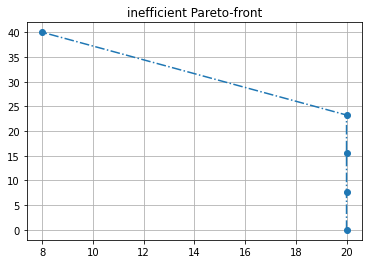

In [67]:
# ## apply normal $\epsilon$-Constraint

model.O_f1.activate()
model.O_f2.deactivate()

model.e = Param(initialize=0, mutable=True)

model.C_epsilon = Constraint(expr = model.f2 == model.e)

solver.solve(model);

print('Each iteration will keep f2 lower than some values between f2_min and f2_max, so ['       + str(f2_min) + ', ' + str(f2_max) + ']')

n = 4
step = int((f2_max - f2_min) / n)
steps = list(range(int(f2_min),int(f2_max),step)) + [f2_max]

x1_l = []
x2_l = []
for i in steps:
    print(i)
    model.e = i
    solver.solve(model);
    x1_l.append(value(model.X1))
    x2_l.append(value(model.X2))
plt.plot(x1_l,x2_l,'o-.');
plt.title('inefficient Pareto-front');
plt.grid(True);




100.0
69.0
38.0
7.0
0.0


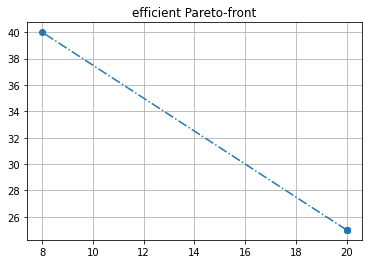

In [68]:
# ## apply augmented $\epsilon$-Constraint

# max   f2 + delta*epsilon <br>
#  s.t. f2 - s = e

model.del_component(model.O_f1)
model.del_component(model.O_f2)
model.del_component(model.C_epsilon)

model.delta = Param(initialize=0.00001)

model.s = Var(within=NonNegativeReals)

model.O_f1 = Objective(expr = model.f1 + model.delta * model.s, sense=maximize)

model.C_e = Constraint(expr = model.f2 - model.s == model.e)

x1_l = []
x2_l = []
for i in steps:
    model.e = i
    solver.solve(model);
    print(model.s.value)
    x1_l.append(value(model.X1))
    x2_l.append(value(model.X2))
plt.plot(x1_l,x2_l,'o-.');
plt.title('efficient Pareto-front');
plt.grid(True);